In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
# Add parent directory to path to import from sibling directories
sys.path.insert(0, str(Path().resolve().parent))
from dataset.cifar10 import load_cifar10, CIFAR10_CLASSES

from softmax_loss import softmax_loss

In [8]:


# Load CIFAR-10 data
# For softmax, we typically use flattened images (each image as a feature vector)
# and normalize the pixel values to [0, 1]
X_train, y_train, X_test, y_test = load_cifar10(flatten_images=True, normalize=True)

print(f"Training set: {X_train.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Test labels: {y_test.shape}")
print(f"Number of classes: {len(CIFAR10_CLASSES)}")
print(f"Class names: {CIFAR10_CLASSES}")


✓ Found existing CIFAR-10 data at: C:\Users\vrpia\OneDrive\Documents\cs231n-deep-learning-for-computer-vision\code\dataset\cifar10\data\cifar-10-batches-py
  Using existing dataset files (no download needed).
Loaded CIFAR-10 dataset:
  Training set: 50000 images, shape (50000, 3072)
  Test set: 10000 images, shape (10000, 3072)
Training set: (50000, 3072)
Training labels: (50000,)
Test set: (10000, 3072)
Test labels: (10000,)
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


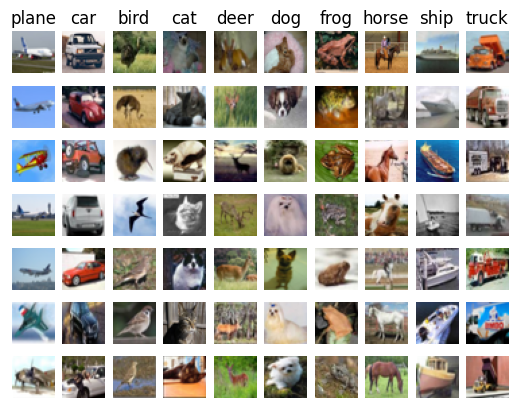

In [9]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

# Reshape function to convert flattened image (3072,) back to (32, 32, 3)
def reshape_image(flat_image):
    """Reshape a flattened CIFAR-10 image (3072,) back to (32, 32, 3)"""
    # CIFAR-10 stores images as RRR...GGG...BBB (row-major order)
    # Reshape from (3072,) to (3, 32, 32)
    image = flat_image.reshape(3, 32, 32)
    # Transpose to (32, 32, 3) - channels last format
    image = image.transpose(1, 2, 0)
    return image

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # Reshape the flattened image and display
        # Since data is normalized to [0, 1], we need to clip and use proper range
        image = reshape_image(X_train[idx])
        plt.imshow(np.clip(image, 0, 1))  # imshow expects [0, 1] for float images
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
from numpy import ma


num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500



mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


[0.51232    0.5100241  0.51357174 0.515628   0.51801956 0.5206599
 0.52272356 0.5247841  0.527116   0.528832  ]


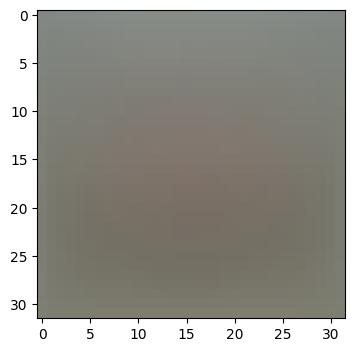

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [11]:
mean_image = np.mean(X_train, axis = 0)
print(mean_image[:10])
plt.figure(figsize=(4,4))
plt.imshow(reshape_image(mean_image)) # visualize the mean image
plt.show()

# center the images
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

In [13]:

W = np.random.randn(3073, 10) * 0.0001

loss, dW = softmax_loss(W, X_dev, y_dev, reg=5e-5)
print(loss, dW)


2.3024354784780177 [[-7.68891644e-03 -7.23124945e-04  6.32497180e-04 ... -7.24961551e-03
  -4.73078207e-03 -6.25833719e-03]
 [-7.91776147e-03  3.26753909e-06  1.49396653e-04 ... -6.91272864e-03
  -4.33747070e-03 -7.70232056e-03]
 [-8.76635184e-03  1.29855902e-03 -5.44392324e-04 ... -6.80599258e-03
  -3.69195169e-03 -9.30121877e-03]
 ...
 [-1.27105420e-02 -4.59203343e-03  2.29945787e-03 ...  4.24326451e-03
   2.34531202e-03 -3.70006379e-03]
 [-1.15154538e-02 -4.84455887e-03  9.37521996e-04 ...  2.80261477e-03
   2.13143641e-03 -3.92231931e-03]
 [-1.40059014e-02 -7.97204403e-03 -1.99883919e-03 ...  2.40003899e-02
   1.79920999e-02  1.39944576e-02]]
